In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 
# Data source : https://www.kaggle.com/c/aptos2019-blindness-detection 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
from os.path import join, isfile
print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

['train.csv', 'sample_submission.csv', 'test.csv', 'train_images', 'test_images']


In [2]:
import tensorflow as tf
from glob import glob
import cv2
from tqdm import tqdm
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Dropout, Flatten, MaxPooling2D
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam
from keras.callbacks import Callback
from sklearn.utils import shuffle
from sklearn.metrics import cohen_kappa_score, accuracy_score
from sklearn.model_selection import train_test_split
print("Tensorflow version: ", tf.__version__)

Using TensorFlow backend.


Tensorflow version:  1.14.0


**Analysis data properties**

In [3]:
# Paths
TRAIN_CSV_PATH = '../input/train.csv'
TEST_CSV_PATH = '../input/test.csv'
TRAIN_IMG_PATH = '../input/train_images/'
TEST_IMG_PATH = '../input/test_images/'

# Image new shape
NEW_SHAPE = 128
BATCH_SIZE = 250
EPOCH = 15
INITIAL_EPOCH = 5
SAMPLING_SIZE = 500

# View no.of rows before loading data
train_rows_count = !wc -l {TRAIN_CSV_PATH}
test_rows_count = !wc -l {TEST_CSV_PATH}
print("Train #rows: {}\nTest #rows: {}".format(train_rows_count[0], test_rows_count[0]))

# Load csv data as DataFrame object
train_df = pd.read_csv(TRAIN_CSV_PATH)  # nrows=50
test_df = pd.read_csv(TEST_CSV_PATH)
print("Train data shape: ", train_df.shape)
print("Test data shape: ", test_df.shape)
print("Columns: ", train_df.columns)
print("Train data:\n", train_df.head(5))
print("Test data:\n", test_df.head(5))

Train #rows: 3663 ../input/train.csv
Test #rows: 1929 ../input/test.csv
Train data shape:  (3662, 2)
Test data shape:  (1928, 1)
Columns:  Index(['id_code', 'diagnosis'], dtype='object')
Train data:
         id_code  diagnosis
0  000c1434d8d7          2
1  001639a390f0          4
2  0024cdab0c1e          1
3  002c21358ce6          0
4  005b95c28852          0
Test data:
         id_code
0  0005cfc8afb6
1  003f0afdcd15
2  006efc72b638
3  00836aaacf06
4  009245722fa4


Value counts;
 0    1805
2     999
1     370
4     295
3     193
Name: diagnosis, dtype: int64


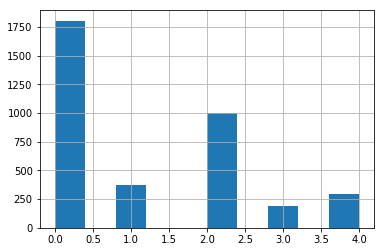

In [4]:
print("Value counts;\n", train_df['diagnosis'].value_counts())
train_df['diagnosis'].hist()

In [5]:
train_img_counts = glob(join(TRAIN_IMG_PATH, '*.png'))
test_img_counts = glob(join(TEST_IMG_PATH, '*.png'))
print("Files count in train directory: ", len(train_img_counts))
print("Files count in test directory: ", len(test_img_counts))

Files count in train directory:  3662
Files count in test directory:  1928


In [6]:
train_df['path'] = train_df['id_code'].map(lambda x:
                                           join(TRAIN_IMG_PATH, '{}.png'.format(x)))
train_df['file_exist'] = train_df['path'].map(lambda x: True if isfile(x) else False)
test_df['path'] = test_df['id_code'].map(lambda x:
                                         join(TEST_IMG_PATH, '{}.png'.format(x)))
test_df['file_exist'] = test_df['path'].map(lambda x:True if isfile(x) else False)

# Diagnosis value distribusion
train_df.head(5)

,id_code,diagnosis,path,file_exist
0,000c1434d8d7,2,../input/train_images/000c1434d8d7.png,True
1,001639a390f0,4,../input/train_images/001639a390f0.png,True
2,0024cdab0c1e,1,../input/train_images/0024cdab0c1e.png,True
3,002c21358ce6,0,../input/train_images/002c21358ce6.png,True
4,005b95c28852,0,../input/train_images/005b95c28852.png,True


In [7]:
# Drop duplicates
train_df = train_df.drop_duplicates()

# Oversampling lower classes
train_df = train_df.groupby(['diagnosis']).apply(lambda x: x.sample(SAMPLING_SIZE,
                                                             replace = True)).reset_index(drop=True)
train_df = shuffle(train_df)

# Train & Test split
train, validation = train_df.copy(), train_df.iloc[:int(train_df.shape[0]*0.15), ]
print('Train & Test split done...')
print("Shape;\nTrain: {}\nTest: {}\n-----".format(train.shape, validation.shape))

Train & Test split done...
Shape;
Train: (2500, 4)
Test: (375, 4)
-----


3    500
1    500
4    500
2    500
0    500
Name: diagnosis, dtype: int64

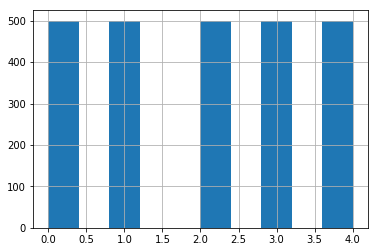

In [8]:
# After sampling
train_df['diagnosis'].hist()
train_df['diagnosis'].value_counts()

20it [00:02,  7.41it/s]


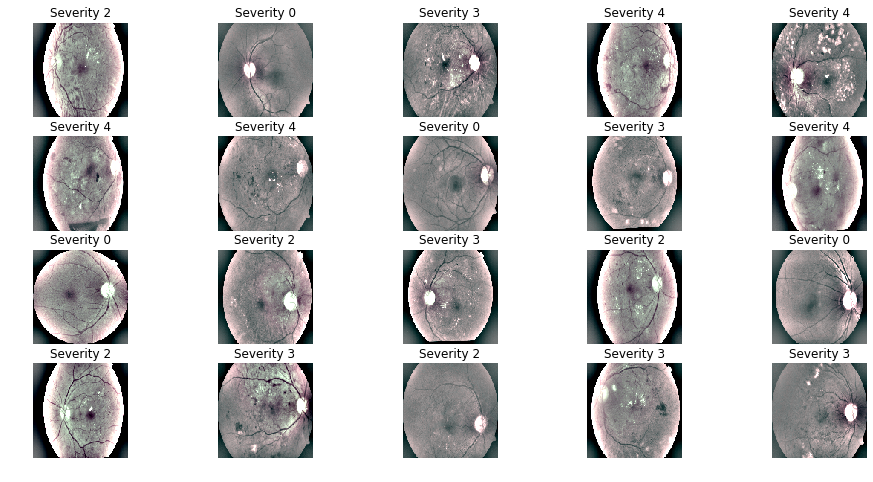

In [9]:
# Show sample images
t_x = train_df['path']
t_y = train_df['diagnosis']
fig, m_axs = plt.subplots(4, 5, figsize=(16, 8))
for (c_x, c_y, c_ax) in tqdm(zip(t_x, t_y, m_axs.flatten())):
    img = cv2.imread(c_x)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img = cv2.resize(img, (NEW_SHAPE, )*2)
    img = cv2.applyColorMap(img, cv2.COLORMAP_BONE)
    img = cv2.addWeighted(img, 4,
                          cv2.GaussianBlur(img, (0, 0),
                                           NEW_SHAPE/10), -4, 128)
    c_ax.imshow(img)
    c_ax.set_title('Severity {}'.format(c_y))
    c_ax.axis('off')


In [10]:
def img_preprocess(img_path, new_size=NEW_SHAPE):
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img = cv2.resize(img, (new_size, )*2).astype(np.uint8)
    img = cv2.applyColorMap(img, cv2.COLORMAP_BONE)
    img = cv2.addWeighted(img, 4,
                          cv2.GaussianBlur(img, (0, 0),
                                           NEW_SHAPE/10), -4, 128)
    return img

print("Training images reading...")
x_train = np.empty((train.shape[0], NEW_SHAPE, NEW_SHAPE, 3), dtype=np.float16)
for i, img_path in enumerate(tqdm(train['path'])):
    x_train[i, :, :, :] = img_preprocess(img_path)
x_train /= 255

print("Testing images reading...")
x_val = np.empty((validation.shape[0], NEW_SHAPE, NEW_SHAPE, 3), dtype=np.float16)
for i, img_path in enumerate(tqdm(validation['path'])):
    x_val[i, :, :, :] = img_preprocess(img_path)
x_val /= 255

print("x_train shape :", x_train.shape)
y_train = train['diagnosis']
y_val = validation['diagnosis']

  0%|          | 1/2500 [00:00<05:51,  7.11it/s]

Training images reading...


  0%|          | 1/375 [00:00<00:58,  6.40it/s]

Testing images reading...


100%|██████████| 375/375 [00:42<00:00,  8.67it/s]


x_train shape : (2500, 128, 128, 3)


Evaluation matric Quadratic Weighted Kappa[(QWK)](https://github.com/benhamner/Metrics/blob/9a637aea795dc6f2333f022b0863398de0a1ca77/Python/ml_metrics/quadratic_weighted_kappa.py#L38)

In [11]:
def confusion_matrix(rater_a, rater_b, min_rating=None, max_rating=None):
    """
    Returns the confusion matrix between rater's ratings
    """
    assert(len(rater_a) == len(rater_b))
    if min_rating is None:
        min_rating = min(rater_a + rater_b)
    if max_rating is None:
        max_rating = max(rater_a + rater_b)
    num_ratings = int(max_rating - min_rating + 1)
    conf_mat = [[0 for i in range(num_ratings)]
                for j in range(num_ratings)]
    for a, b in zip(rater_a, rater_b):
        conf_mat[a - min_rating][b - min_rating] += 1
    return conf_mat


def histogram(ratings, min_rating=None, max_rating=None):
    """
    Returns the counts of each type of rating that a rater made
    """
    if min_rating is None:
        min_rating = min(ratings)
    if max_rating is None:
        max_rating = max(ratings)
    num_ratings = int(max_rating - min_rating + 1)
    hist_ratings = [0 for x in range(num_ratings)]
    for r in ratings:
        hist_ratings[r - min_rating] += 1
    return hist_ratings


def quadratic_weighted_kappa(rater_a, rater_b, min_rating=None, max_rating=None):
    """
    Calculates the quadratic weighted kappa
    quadratic_weighted_kappa calculates the quadratic weighted kappa
    value, which is a measure of inter-rater agreement between two raters
    that provide discrete numeric ratings.  Potential values range from -1
    (representing complete disagreement) to 1 (representing complete
    agreement).  A kappa value of 0 is expected if all agreement is due to
    chance.
    quadratic_weighted_kappa(rater_a, rater_b), where rater_a and rater_b
    each correspond to a list of integer ratings.  These lists must have the
    same length.
    The ratings should be integers, and it is assumed that they contain
    the complete range of possible ratings.
    quadratic_weighted_kappa(X, min_rating, max_rating), where min_rating
    is the minimum possible rating, and max_rating is the maximum possible
    rating
    """
    rater_a = np.array(rater_a, dtype=int)
    rater_b = np.array(rater_b, dtype=int)
    assert(len(rater_a) == len(rater_b))
    if min_rating is None:
        min_rating = min(min(rater_a), min(rater_b))
    if max_rating is None:
        max_rating = max(max(rater_a), max(rater_b))
    conf_mat = confusion_matrix(rater_a, rater_b,
                                min_rating, max_rating)
    num_ratings = len(conf_mat)
    num_scored_items = float(len(rater_a))

    hist_rater_a = histogram(rater_a, min_rating, max_rating)
    hist_rater_b = histogram(rater_b, min_rating, max_rating)

    numerator = 0.0
    denominator = 0.0

    for i in range(num_ratings):
        for j in range(num_ratings):
            expected_count = (hist_rater_a[i] * hist_rater_b[j]
                              / num_scored_items)
            d = pow(i - j, 2.0) / pow(num_ratings - 1, 2.0)
            numerator += d * conf_mat[i][j] / num_scored_items
            denominator += d * expected_count / num_scored_items

    return 1.0 - numerator / denominator


def linear_weighted_kappa(rater_a, rater_b, min_rating=None, max_rating=None):
    """
    Calculates the linear weighted kappa
    linear_weighted_kappa calculates the linear weighted kappa
    value, which is a measure of inter-rater agreement between two raters
    that provide discrete numeric ratings.  Potential values range from -1
    (representing complete disagreement) to 1 (representing complete
    agreement).  A kappa value of 0 is expected if all agreement is due to
    chance.
    linear_weighted_kappa(rater_a, rater_b), where rater_a and rater_b
    each correspond to a list of integer ratings.  These lists must have the
    same length.
    The ratings should be integers, and it is assumed that they contain
    the complete range of possible ratings.
    linear_weighted_kappa(X, min_rating, max_rating), where min_rating
    is the minimum possible rating, and max_rating is the maximum possible
    rating
    """
    assert(len(rater_a) == len(rater_b))
    if min_rating is None:
        min_rating = min(rater_a + rater_b)
    if max_rating is None:
        max_rating = max(rater_a + rater_b)
    conf_mat = confusion_matrix(rater_a, rater_b,
                                min_rating, max_rating)
    num_ratings = len(conf_mat)
    num_scored_items = float(len(rater_a))

    hist_rater_a = histogram(rater_a, min_rating, max_rating)
    hist_rater_b = histogram(rater_b, min_rating, max_rating)

    numerator = 0.0
    denominator = 0.0

    for i in range(num_ratings):
        for j in range(num_ratings):
            expected_count = (hist_rater_a[i] * hist_rater_b[j]
                              / num_scored_items)
            d = abs(i - j) / float(num_ratings - 1)
            numerator += d * conf_mat[i][j] / num_scored_items
            denominator += d * expected_count / num_scored_items

    return 1.0 - numerator / denominator


def kappa(rater_a, rater_b, min_rating=None, max_rating=None):
    """
    Calculates the kappa
    kappa calculates the kappa
    value, which is a measure of inter-rater agreement between two raters
    that provide discrete numeric ratings.  Potential values range from -1
    (representing complete disagreement) to 1 (representing complete
    agreement).  A kappa value of 0 is expected if all agreement is due to
    chance.
    kappa(rater_a, rater_b), where rater_a and rater_b
    each correspond to a list of integer ratings.  These lists must have the
    same length.
    The ratings should be integers, and it is assumed that they contain
    the complete range of possible ratings.
    kappa(X, min_rating, max_rating), where min_rating
    is the minimum possible rating, and max_rating is the maximum possible
    rating
    """
    assert(len(rater_a) == len(rater_b))
    if min_rating is None:
        min_rating = min(rater_a + rater_b)
    if max_rating is None:
        max_rating = max(rater_a + rater_b)
    conf_mat = confusion_matrix(rater_a, rater_b,
                                min_rating, max_rating)
    num_ratings = len(conf_mat)
    num_scored_items = float(len(rater_a))

    hist_rater_a = histogram(rater_a, min_rating, max_rating)
    hist_rater_b = histogram(rater_b, min_rating, max_rating)

    numerator = 0.0
    denominator = 0.0

    for i in range(num_ratings):
        for j in range(num_ratings):
            expected_count = (hist_rater_a[i] * hist_rater_b[j]
                              / num_scored_items)
            if i == j:
                d = 0.0
            else:
                d = 1.0
            numerator += d * conf_mat[i][j] / num_scored_items
            denominator += d * expected_count / num_scored_items

    return 1.0 - numerator / denominator


def mean_quadratic_weighted_kappa(kappas, weights=None):
    """
    Calculates the mean of the quadratic
    weighted kappas after applying Fisher's r-to-z transform, which is
    approximately a variance-stabilizing transformation.  This
    transformation is undefined if one of the kappas is 1.0, so all kappa
    values are capped in the range (-0.999, 0.999).  The reverse
    transformation is then applied before returning the result.
    mean_quadratic_weighted_kappa(kappas), where kappas is a vector of
    kappa values
    mean_quadratic_weighted_kappa(kappas, weights), where weights is a vector
    of weights that is the same size as kappas.  Weights are applied in the
    z-space
    """
    kappas = np.array(kappas, dtype=float)
    if weights is None:
        weights = np.ones(np.shape(kappas))
    else:
        weights = weights / np.mean(weights)

    # ensure that kappas are in the range [-.999, .999]
    kappas = np.array([min(x, .999) for x in kappas])
    kappas = np.array([max(x, -.999) for x in kappas])

    z = 0.5 * np.log((1 + kappas) / (1 - kappas)) * weights
    z = np.mean(z)
    return (np.exp(2 * z) - 1) / (np.exp(2 * z) + 1)


def weighted_mean_quadratic_weighted_kappa(solution, submission):
    predicted_score = submission[submission.columns[-1]].copy()
    predicted_score.name = "predicted_score"
    if predicted_score.index[0] == 0:
        predicted_score = predicted_score[:len(solution)]
        predicted_score.index = solution.index
    combined = solution.join(predicted_score, how="left")
    groups = combined.groupby(by="essay_set")
    kappas = [quadratic_weighted_kappa(group[1]["essay_score"], group[1]["predicted_score"]) for group in groups]
    weights = [group[1]["essay_weight"].irow(0) for group in groups]
    return mean_quadratic_weighted_kappa(kappas, weights=weights)

Also Keras callback for [QWK](https://www.kaggle.com/xhlulu/aptos-2019-densenet-keras-starter)

In [12]:
class Metrics(Callback):
    def on_train_begin(self, logs={}):
        self.val_kappas = []

    def on_epoch_end(self, epoch, logs={}):
        X_val, y_val = self.validation_data[:2]
        y_val = y_val.sum(axis=1) - 1
        
        y_pred = self.model.predict(X_val) > 0.5
        y_pred = y_pred.astype(int).sum(axis=1) - 1

        _val_kappa = cohen_kappa_score(
            y_val,
            y_pred, 
            weights='quadratic'
        )

        self.val_kappas.append(_val_kappa)

        print(f"val_kappa: {_val_kappa:.4f}")
        
        if _val_kappa == max(self.val_kappas):
            print("Validation Kappa has improved. Saving model.")
            self.model.save('model.h5')

        return


In [13]:
# Model compile and fitting
def get_model():
    '''
    Get compiled model\n
    '''
    # Create a sequential model and add layers
    input_shape = (NEW_SHAPE, NEW_SHAPE, 3)
    model = Sequential()
    model.add(Conv2D(BATCH_SIZE, kernel_size=(3, )*2, input_shape=input_shape))
    model.add(MaxPooling2D(pool_size=(2, )*2))
    model.add(Dropout(0.25))
    model.add(Flatten())
    # Dense : dot(input, kernal) + bias
    model.add(Dense(128, activation=tf.nn.relu))
    model.add(Dropout(0.2))
    # 5 labels for output
    model.add(Dense(5, activation=tf.nn.softmax))
    
    compile_args = {
        'optimizer': Adam(lr=0.0001),
        'loss': 'sparse_categorical_crossentropy',
        'metrics': ['accuracy']
    }
    model.compile(**compile_args)
    
    return model


Epoch 6/15
10/10 [==============================] - 144s 14s/step - loss: 1.6092 - acc: 0.2140 - val_loss: 5.0284 - val_acc: 0.2507
val_kappa: -0.0213
Validation Kappa has improved. Saving model.
Epoch 7/15
10/10 [==============================] - 132s 13s/step - loss: 1.6040 - acc: 0.2616 - val_loss: 11.4399 - val_acc: 0.2133
val_kappa: 0.0000
Validation Kappa has improved. Saving model.
Epoch 8/15
10/10 [==============================] - 132s 13s/step - loss: 1.5975 - acc: 0.2704 - val_loss: 9.3224 - val_acc: 0.3120
val_kappa: 0.0000
Validation Kappa has improved. Saving model.
Epoch 9/15
10/10 [==============================] - 133s 13s/step - loss: 1.5876 - acc: 0.2760 - val_loss: 9.5476 - val_acc: 0.3440
val_kappa: -0.0029
Epoch 10/15
10/10 [==============================] - 131s 13s/step - loss: 1.5738 - acc: 0.3020 - val_loss: 9.6423 - val_acc: 0.3627
val_kappa: 0.0000
Validation Kappa has improved. Saving model.
Epoch 11/15
10/10 [==============================] - 133s 13s/step

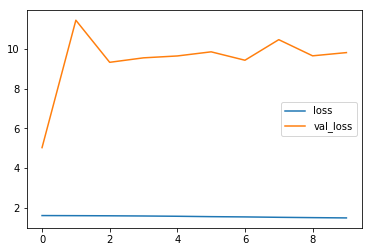

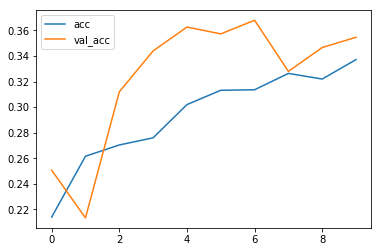

In [14]:
model = get_model()

# Docs: https://keras.io/models/model/
# fit_args = {
#     'x': x_train,
#     'y': y_train,
#     'batch_size': BATCH_SIZE
#     'epochs': EPOCH,
#     'validation_data': (x_val, y_val),
#     'shuffle': True,
#     'initial_epoch': INITIAL_EPOCH
# }
# history = model.fit(**fit_args)

# OR
generator_args = {
    'zoom_range': 0.15,
    'fill_mode': 'nearest',
    'cval': 0.,
    'horizontal_flip': True,
    'vertical_flip': True,
    'rotation_range': 45,
    'shear_range': 0.15,
    'rescale': 1.0/255
}
kappa_metrics = Metrics()
fit_args = {
    'generator': ImageDataGenerator(**generator_args).flow(x_train,
                                           y_train,
                                           batch_size=BATCH_SIZE),
    'epochs': EPOCH,
    'validation_data': (x_val, y_val),
    'shuffle': True,
    'initial_epoch': INITIAL_EPOCH,
    'steps_per_epoch': x_train.shape[0]/BATCH_SIZE,
    'callbacks': [kappa_metrics]
}
history = model.fit_generator(**fit_args)
history_df = pd.DataFrame(history.history)
history_df[['loss', 'val_loss']].plot()
history_df[['acc', 'val_acc']].plot()

# Evaluate
eval_args = {
    'x': x_val,
    'y': y_val,
    'batch_size': BATCH_SIZE
}
model.evaluate(**eval_args)
# Kappa evaluation on validation set
pred_args = {
    'x': x_val,
    'batch_size': BATCH_SIZE
}
pred = model.predict(**pred_args)
val_pred = pred.astype('int').argmax(axis=1)
# print("Kappa evaluation on validation set...")
# quadratic_weighted_kappa(prediction, y_val)

In [15]:
# Test and submission
x_test = np.empty((test_df.shape[0], NEW_SHAPE, NEW_SHAPE, 3), dtype=np.float16)
for i, img_path in enumerate(tqdm(test_df['path'])):
    x_test[i, :, : , :] = img_preprocess(img_path)
x_test /= 255
    
pred_args = {
    'x': x_test,
    'batch_size': BATCH_SIZE
}
prediction = model.predict(**pred_args)
test_df['diagnosis'] = prediction.astype('int').argmax(axis=1)
pred_df = test_df[['id_code', 'diagnosis']]

# Save predictions to submission.csv
pred_df.to_csv('submission.csv', index=False)
pred_df.head(10)

100%|██████████| 1928/1928 [01:12<00:00, 26.77it/s]


,id_code,diagnosis
0,0005cfc8afb6,0
1,003f0afdcd15,4
2,006efc72b638,0
3,00836aaacf06,4
4,009245722fa4,0
5,009c019a7309,0
6,010d915e229a,2
7,0111b949947e,0
8,01499815e469,0
9,0167076e7089,0


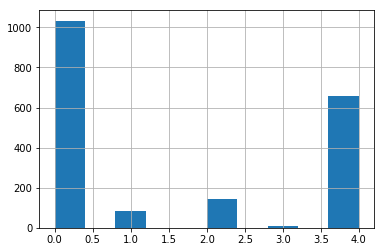

In [16]:
# Prediction distribution
pred_df['diagnosis'].hist()